<a href="https://colab.research.google.com/github/ELiTE0005/DeepLearningTechniques/blob/main/exp3___study_of_the_classifiers_with_respect_to_statistical_paramters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classifier Performance Summary (Mean ± Std over 10-fold CV):

RandomForest:
  accuracy: 0.9561 ± 0.0239
  precision_macro: 0.9559 ± 0.0227
  recall_macro: 0.9514 ± 0.0300
  f1_macro: 0.9526 ± 0.0264
  roc_auc: 0.9893 ± 0.0147

LogisticRegression:
  accuracy: 0.9526 ± 0.0222
  precision_macro: 0.9549 ± 0.0192
  recall_macro: 0.9456 ± 0.0307
  f1_macro: 0.9485 ± 0.0254
  roc_auc: 0.9925 ± 0.0077

GaussianNB:
  accuracy: 0.9368 ± 0.0305
  precision_macro: 0.9413 ± 0.0285
  recall_macro: 0.9263 ± 0.0396
  f1_macro: 0.9308 ± 0.0349
  roc_auc: 0.9889 ± 0.0084

KNN:
  accuracy: 0.9350 ± 0.0293
  precision_macro: 0.9380 ± 0.0268
  recall_macro: 0.9250 ± 0.0388
  f1_macro: 0.9290 ± 0.0343
  roc_auc: 0.9651 ± 0.0315

DecisionTree:
  accuracy: 0.9262 ± 0.0233
  precision_macro: 0.9264 ± 0.0279
  recall_macro: 0.9200 ± 0.0237
  f1_macro: 0.9208 ± 0.0248
  roc_auc: 0.9200 ± 0.0237

SVM (RBF):
  accuracy: 0.9156 ± 0.0367
  precision_macro: 0.9303 ± 0.0313
  recall_macro: 0.8931 ± 0.0490
  f1_macro: 

/tmp/ipython-input-3150137569.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(acc_data, labels=summary_df['classifier'], vert=True)


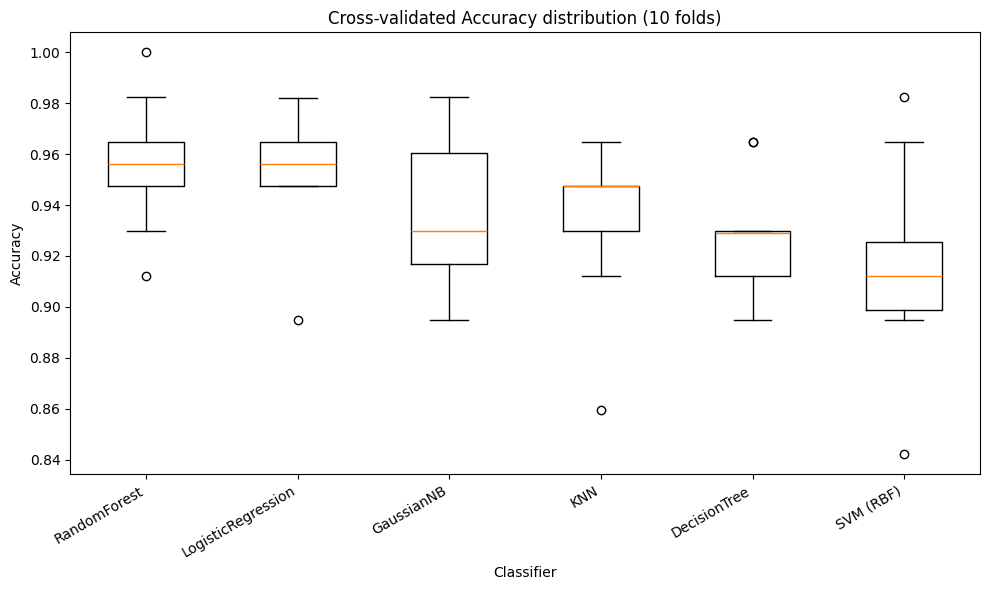


Paired t-test between 'RandomForest' and 'LogisticRegression' (accuracy):
  t-statistic = 0.5614, p-value = 0.588254
  => No significant difference (p ≥ 0.05).


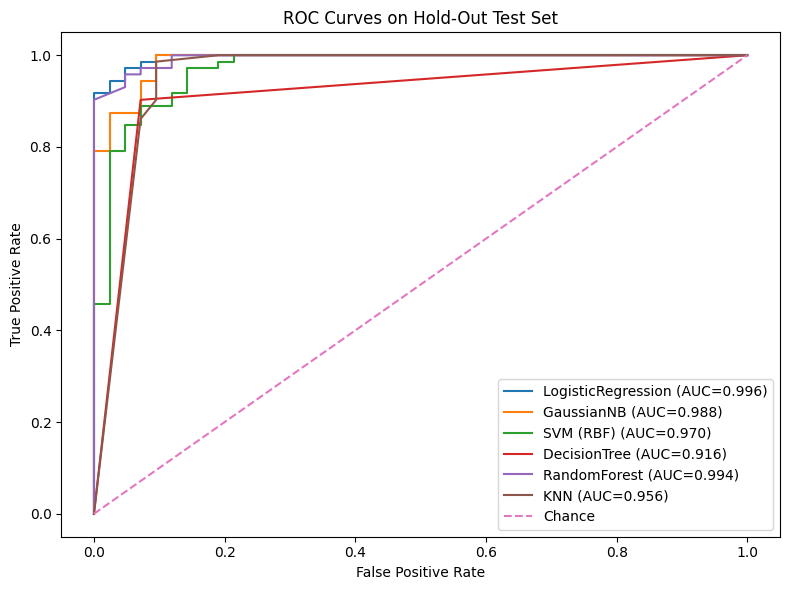

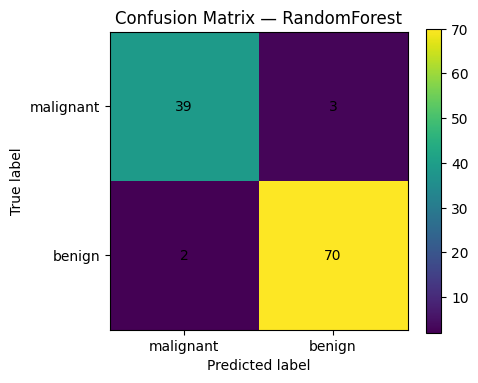

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=10000, solver='liblinear'),
    "GaussianNB": GaussianNB(),
    "SVM (RBF)": SVC(probability=True, kernel='rbf', gamma='scale'),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

results_per_classifier = {}
for name, clf in classifiers.items():
    results_per_classifier[name] = {}
    for metric_name, scoring in scoring_metrics.items():
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        results_per_classifier[name][metric_name] = scores
    try:
        roc_scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    except:
        roc_scores = np.full(cv.get_n_splits(), np.nan)
    results_per_classifier[name]['roc_auc'] = roc_scores

summary_rows = []
for name, metrics_dict in results_per_classifier.items():
    row = {"classifier": name}
    for metric in list(scoring_metrics.keys()) + ['roc_auc']:
        vals = metrics_dict[metric]
        row[f"{metric}_mean"] = np.nanmean(vals)
        row[f"{metric}_std"] = np.nanstd(vals)
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows).sort_values(by='accuracy_mean', ascending=False).reset_index(drop=True)

print("Classifier Performance Summary (Mean ± Std over 10-fold CV):\n")
for index, row in summary_df.iterrows():
    print(f"{row['classifier']}:")
    for metric in list(scoring_metrics.keys()) + ['roc_auc']:
        mean = row[f"{metric}_mean"]
        std = row[f"{metric}_std"]
        print(f"  {metric}: {mean:.4f} ± {std:.4f}")
    print()

plt.figure(figsize=(10,6))
acc_data = [results_per_classifier[name]['accuracy'] for name in summary_df['classifier']]
plt.boxplot(acc_data, labels=summary_df['classifier'], vert=True)
plt.title("Cross-validated Accuracy distribution (10 folds)")
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

top_two = summary_df['classifier'].iloc[:2].tolist()
acc_top1 = results_per_classifier[top_two[0]]['accuracy']
acc_top2 = results_per_classifier[top_two[1]]['accuracy']
t_stat, p_value = ttest_rel(acc_top1, acc_top2)
print(f"\nPaired t-test between '{top_two[0]}' and '{top_two[1]}' (accuracy):")
print(f"  t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
if p_value < 0.05:
    print("  => Statistically significant difference (p < 0.05).")
else:
    print("  => No significant difference (p ≥ 0.05).")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
plt.figure(figsize=(8,6))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        probas_ = clf.predict_proba(X_test)[:,1]
    elif hasattr(clf, "decision_function"):
        probas_ = clf.decision_function(X_test)
    else:
        probas_ = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, probas_)
    auc = roc_auc_score(y_test, probas_)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend()
plt.tight_layout()
plt.show()

best_name = summary_df['classifier'].iloc[0]
best_clf = classifiers[best_name]
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1], target_names)
plt.yticks([0,1], target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()
